# Dealing with uncertainty using Bayesian Linear Regression

Code to show a Bayesian approach for the problems discussed in this blog: https://www.yuritan.nl/posts/prediction_uncertainty/. For more in-depth explaination, please check out the blog!

In [17]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pymc3 as pm

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from functools import partial
from scipy import stats, interpolate
from src.data import generate_dataset
from src.visualization import beautify_ax

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generating data
Generating a dataset with a increasing variance. This allows to demonstrate differences in uncertainty, which should be higher when x increases.

In [18]:
np.random.seed(42)
x, x_test, y, y_test = generate_dataset(n=500, test_size=.2)

## Plotting the data 

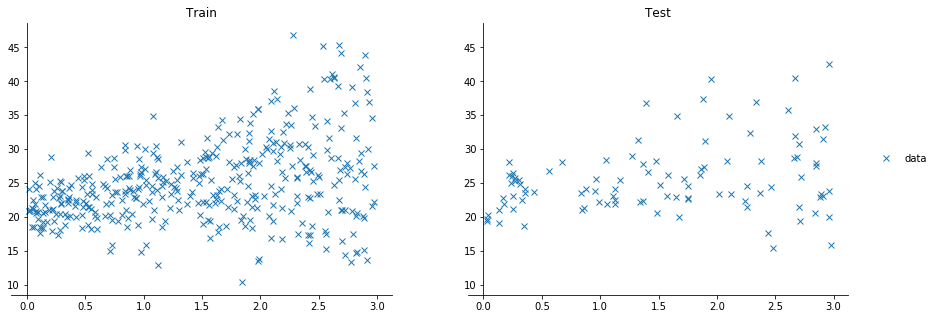

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))

axes[0] = beautify_ax(axes[0])
axes[0].plot(x, y, 'x', label='data')
axes[0].set_title("Train")

axes[1] = beautify_ax(axes[1])
axes[1].plot(x_test, y_test, 'x', label='data')
axes[1].set_title("Test")

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));

## Scaling the data
To make sure the feature $x$ and target $y$ are in the same scale

In [20]:
ssx = MinMaxScaler()
x = ssx.fit_transform(x)
x_test = ssx.transform(x_test)

ssy = MinMaxScaler()
y = ssy.fit_transform(y)
y_test = ssy.transform(y_test)

## The Bayesian approach

**Increasing variance**:

$\sigma_{scale} \sim Normal(0, 10)$

$\sigma_{bias} \sim HalfNormal(10)$

$\sigma = \sigma_{bias} + \sigma_{scale} * x$

**Priors**:

$\alpha \sim Normal(0, 10)$

$\beta \sim Normal(0, 10)$

Linear Regression: $\mu = \alpha + \beta x$

**Likelihood**: 

$y \sim Normal(\mu, \sigma)$

As you can see on the plot, the variance increases when x increases. Therefore I made sure that the variance($\sigma$) depends on $x$.

## Modelling in PyMC3
First, create a Theano `(Tensor)SharedVariable` from the input features $x$ and observations $y$. This is required to switch them for test data during inference.

In [5]:
from theano import shared
x_tensor = shared(x)
y_tensor = shared(y)

Modelling a linear regression with increasing variance. 

In [6]:
def blr_model(x_, y_):
    with pm.Model() as m:
        alpha = pm.Normal('alpha', 0, 10)
        beta = pm.Normal('beta', 0, 10)
        mu = pm.Deterministic('mu', alpha + beta * x_)
        sd_scale = pm.Normal('sd_scale', mu=0, sd=10)
        sd_bias = pm.HalfNormal('sd_bias', sd=10) + 1e-5
        sd = pm.Deterministic('sigma', sd_bias + mu * sd_scale)
        obs = pm.Normal('obs', mu, sd=sd, observed=y_)
        return m
        
with blr_model(x_tensor, y_tensor) as blr:
    trace = pm.sample(1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_bias, sd_scale, beta, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1308.53draws/s]
The acceptance probability does not match the target. It is 0.8837377990821433, but should be close to 0.8. Try to increase the number of tuning steps.


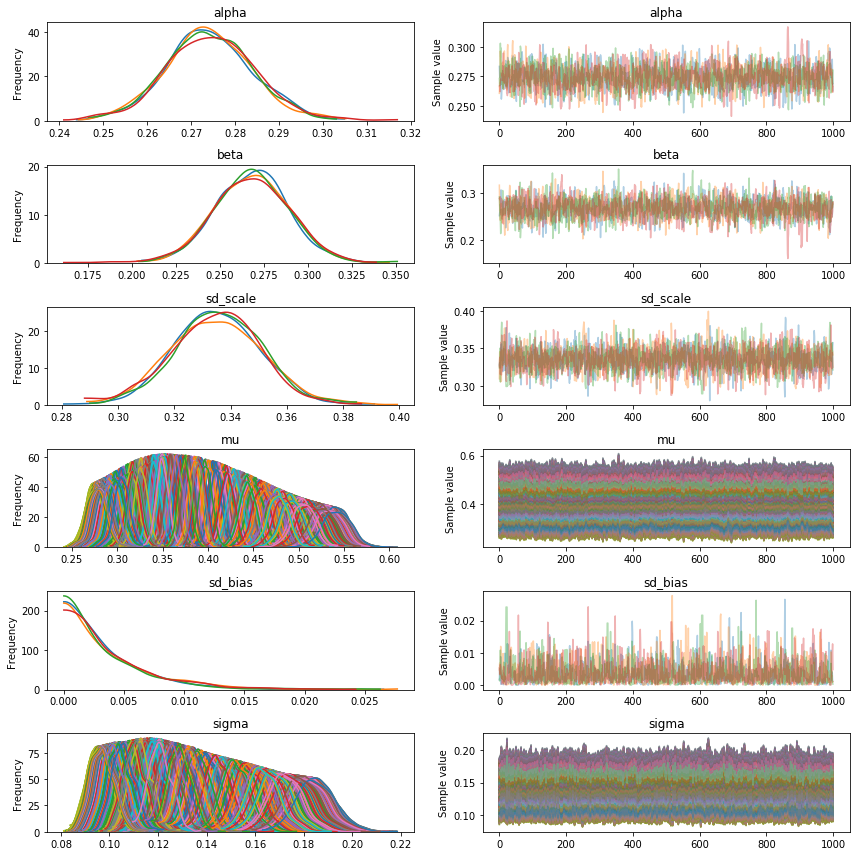

In [7]:
pm.traceplot(trace);

## Store trace 

In [8]:
fname = '../models/BLR.trace'
pm.save_trace(trace, directory=fname, overwrite=True)

'../models/BLR.trace'

## Load trace and sample from the posterior
From the 'train' set, and store them for possible future usage.

In [9]:
with blr_model(x_tensor, y_tensor) as blr:
    trace = pm.load_trace(fname)
    n_samples = len(trace) * trace.nchains
    posterior = pm.sample_ppc(trace, model=blr, samples=n_samples)
    
np.save('../data/blr_posterior_samples_train', posterior['obs'])
posterior['obs'].shape

100%|██████████| 4000/4000 [00:54<00:00, 73.09it/s]


(4000, 400, 1)

## Postprocessing
Sort and calculate credible intervals (2$ * \sigma$) for visualization. Sigma is modeled seperately, which makes this calculation simple

In [10]:
sorting_mask = np.argsort(x, axis=0).flatten()
x_ = x[sorting_mask]
mu = (trace['alpha'] + trace['beta'] * x_)
sigma = np.transpose(np.squeeze(trace['sigma'], axis=-1))[sorting_mask, ...]
quantile_preds = np.array([
    mu - 2 * sigma, 
    mu - 1 * sigma,
    mu, 
    mu + 1 * sigma, 
    mu + 2 * sigma
])

## Plotting median and credible interval (2$*\sigma$)
This plot is also made in notebook 1.0. But there is a slight difference. Here the upper and lower limits are depending on the mean, whereas the MCDQRNN predicts independent quantiles. (Also, the MCDQRNN predicts the median, whereas this BLR predicts the mean)

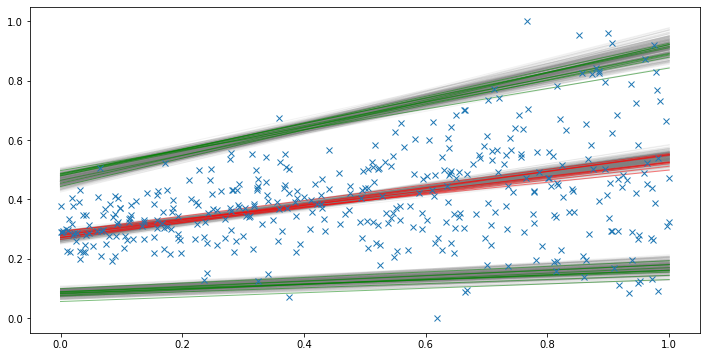

In [11]:
plt.figure(figsize=(12, 6))
n = 300
n_c = 10

plt.plot(x_, mu[..., :n], alpha=.1, lw=1, c='grey')
plt.plot(x_, quantile_preds[0, :, :n], alpha=.1, lw=1, c='grey')
plt.plot(x_, quantile_preds[-1, :, :n], alpha=.1, lw=1, c='grey')
plt.plot(x_, mu[..., n:n+n_c], alpha=.5, lw=1, c='red')
plt.plot(x_, quantile_preds[0][:, n:n+n_c], alpha=.5, lw=1, c='green')
plt.plot(x_, quantile_preds[-1][:, n:n+n_c], alpha=.5, lw=1, c='green')
plt.plot(x, y, 'x');

## Predicting on the test set
Change value of the *SharedTensor* with the test input features, and set observations ($y$) to zeros as dummy.

`EDIT`
In PyMC3 version 3.7 (using 3.6 here), they've introduced a cleaner way (2 new features) of dealing with this shared thensor:
- Add data container class (Data) that wraps the theano SharedVariable class and let the model be aware of its inputs and outputs.
- Add function set_data to update variables defined as Data.

In [12]:
x_tensor.set_value(x_test)
y_tensor.set_value(np.zeros((x_test.shape[0], 1)))
n_samples = len(trace) * trace.nchains
posterior = pm.sample_ppc(trace, model=blr, samples=n_samples)
posterior['obs'].shape

100%|██████████| 4000/4000 [00:57<00:00, 69.75it/s]


(4000, 100, 1)

## Save posterior sample
For future plots

In [13]:
np.save('../data/blr_posterior_samples_test', posterior['obs'])
posterior_obs = np.load('../data/blr_posterior_samples_test.npy')

## Looking at individual predictions
You can see that the distributions are normally distributed, with different levels of uncertainty. (higher input value of $x$ should result into higher uncertainty)

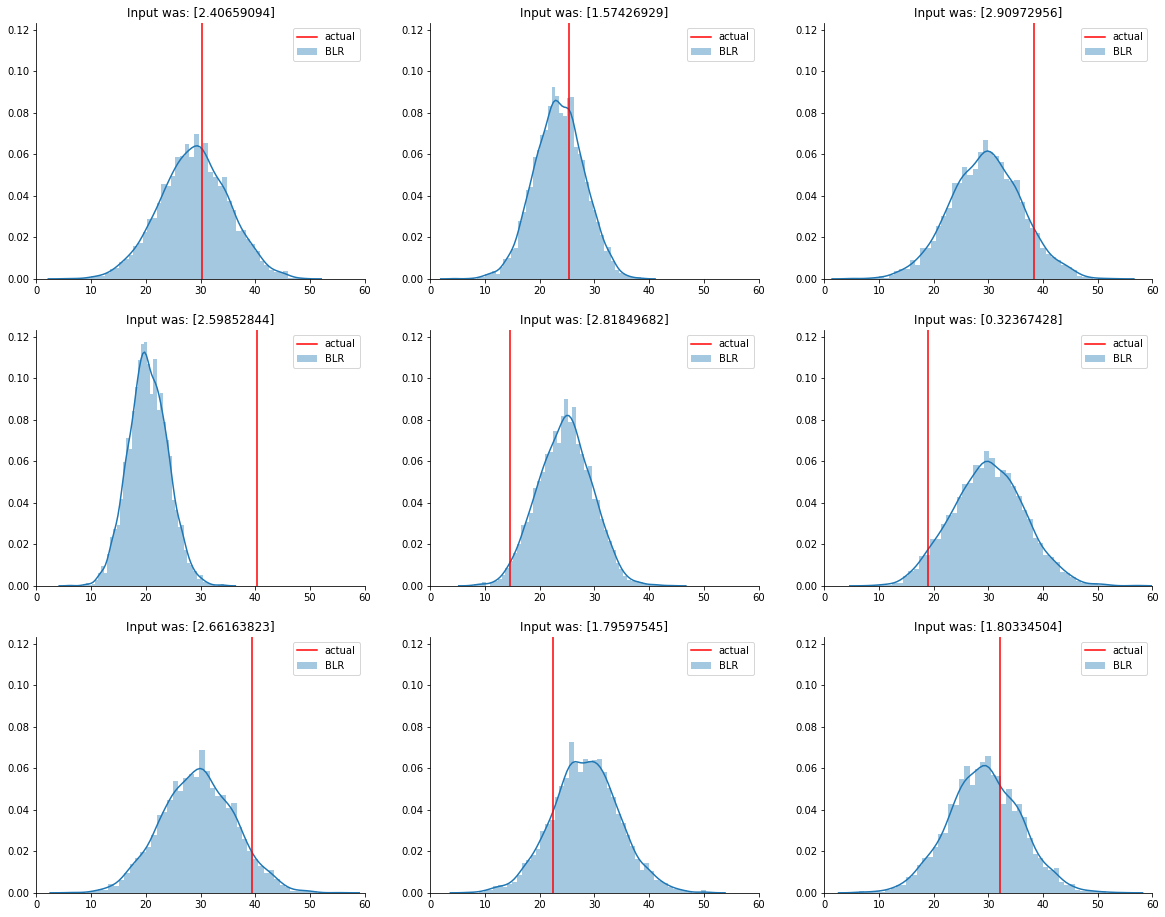

In [14]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))
for i, ax in enumerate(axes.flat):
    i = np.random.randint(0, 100)
    ax = beautify_ax(ax)
    blr_posterior = ssy.inverse_transform(posterior_obs[:, i, 0].reshape(-1,1))
    sns.distplot(blr_posterior, bins=50, ax=ax, label='BLR')
    ax.axvline(ssy.inverse_transform(y)[i], c='r', label='actual')
    ax.set_title(f"Input was: {ssx.inverse_transform(x)[i]}")
    ax.legend()
    ax.set_xlim(0, 60)
    
plt.show()

## Extra
In case we want to get similar results as the MCDQRNN (see notebook 1.0). In this case, we do it exactly the other way around. We first sample from the posterior, and then we can estimate the quantiles (no quantile crossover!).

In [15]:
from src.models.quantile_utils import create_quantiles
QUANTILES = create_quantiles(11, min_q=0.01, max_q=0.99)

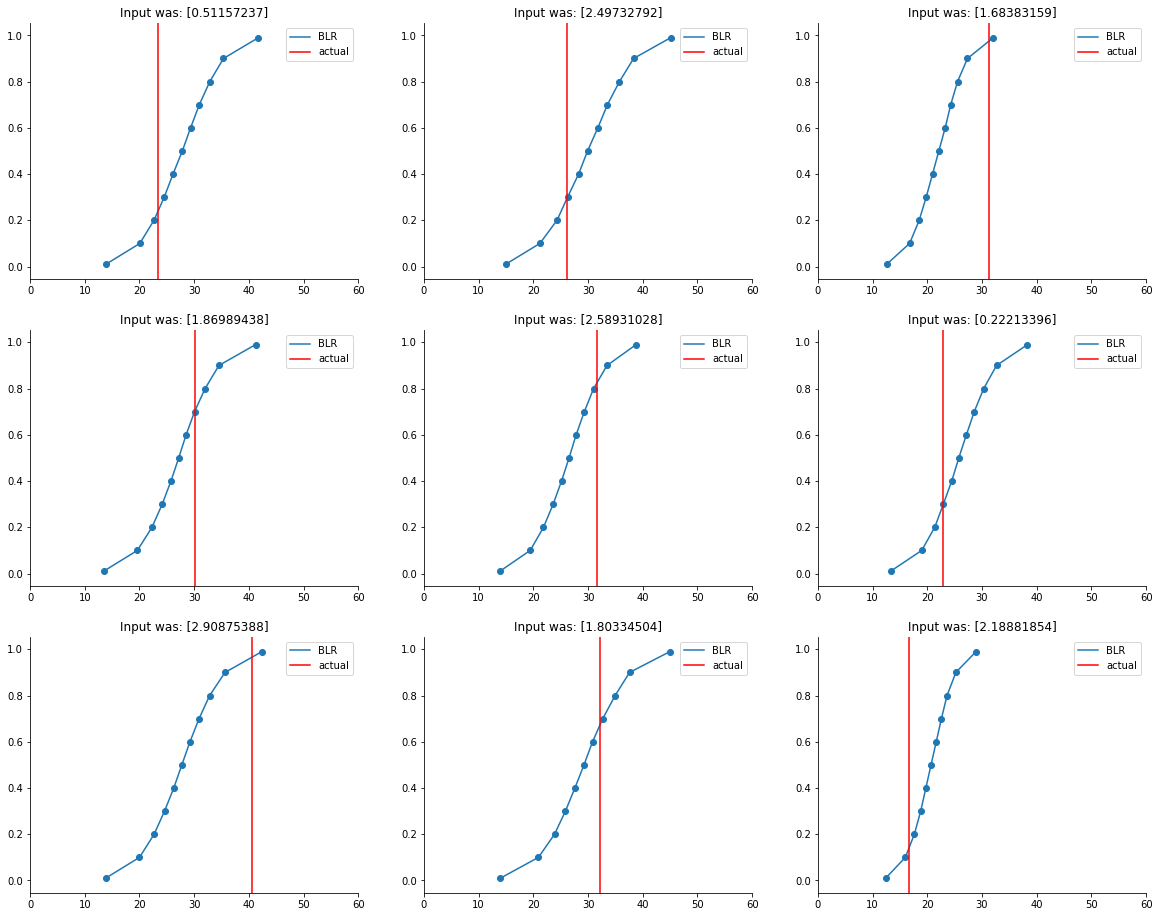

In [16]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))
for i, ax in enumerate(axes.flat):
    i = np.random.randint(0, 100)
    ax = beautify_ax(ax)
    blr_posterior = ssy.inverse_transform(posterior_obs[:, i, 0].reshape(-1,1))
    qs_from_posterior = np.quantile(blr_posterior, QUANTILES)
    ax.plot(qs_from_posterior, QUANTILES, label='BLR')
    ax.scatter(qs_from_posterior, QUANTILES)
    ax.axvline(ssy.inverse_transform(y)[i], c='r', label='actual')
    ax.set_title(f"Input was: {ssx.inverse_transform(x)[i]}")
    ax.legend()
    ax.set_xlim(0, 60)
    
plt.show()